# Customer Churn - Modeling

## Imports

In [604]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from pprint import pprint


## Read in data 

In [605]:
df = pd.read_csv('data/processed/customer_churn_fe.csv')
#df.head()
#df.info()

In [606]:
# split into x and y variables

# target variable - churn
y = df['Churn']

# x variables
X = df.drop(columns='Churn')

#print("\nTarget variable:")
#print(y.head())

#print("\nX variables:")
#X.head()
#X.info()

In [607]:
# check for imbalance data in our target variable
print(y.value_counts())

Churn
0    5174
1    1869
Name: count, dtype: int64


since our target variable is imbalanced, let's try to oversample the minority to ensure our model can accurately predict

In [608]:
from imblearn.over_sampling import SMOTE

# resampling 
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

In [609]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled, test_size=0.2, random_state=23)

scalar = StandardScaler()

X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)

## Logistic Regression

First, we will a baseline model - the logistic regression to get a fundamental understanding of our data and how well our a baseline model performs with it.

### Fit model

In [610]:
# instantiate the model
log_model = LogisticRegression(random_state=23)
log_model.fit(X_train,y_train)
y_pred = log_model.predict(X_test)


### Confusion Matrix

In [611]:
# confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print(cnf_matrix)

[[853 184]
 [159 874]]


Text(50.722222222222214, 0.5, 'Actual label')

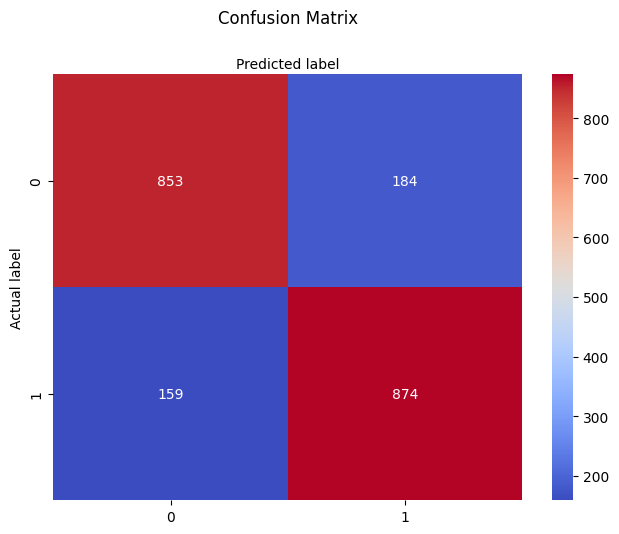

In [612]:
# visualize confusion matrix with a heatmap
class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='coolwarm', fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion Matrix", y=1.1)
plt.xlabel("Predicted label")
plt.ylabel("Actual label")

### Classification Report

In [613]:
target_names = ["no churn", "churn"]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    no churn       0.84      0.82      0.83      1037
       churn       0.83      0.85      0.84      1033

    accuracy                           0.83      2070
   macro avg       0.83      0.83      0.83      2070
weighted avg       0.83      0.83      0.83      2070



When it comes to analyzing our model results, we want to focus on the false negatives - in this case the recall. 
The close the recall is to 1 then the better our model is at identifying true negatives.This is especially important in predicting customer churn because any false negatives is missed revenue

### Area Under the Curve

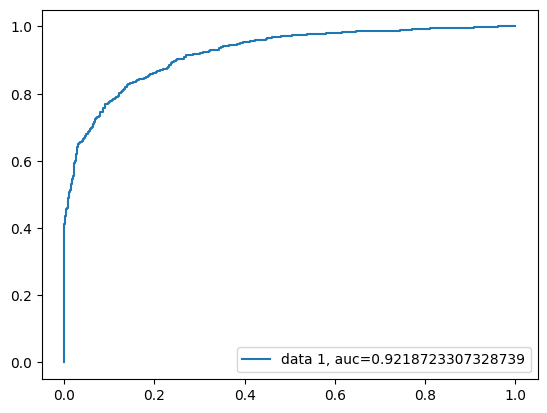

In [614]:
y_pred_prob = log_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Random Forest Classifier

### Fit model

In [615]:
rf = RandomForestClassifier(random_state=23)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

### Confusion Matrix

In [616]:
rf_cnf_matrix = confusion_matrix(y_test,y_pred)
print(rf_cnf_matrix)

[[  44  993]
 [  13 1020]]


### Classification Report

In [617]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.77      0.04      0.08      1037
           1       0.51      0.99      0.67      1033

    accuracy                           0.51      2070
   macro avg       0.64      0.51      0.38      2070
weighted avg       0.64      0.51      0.37      2070



The base Random Forest model can predict customer churn very well but lacks the accuracy in predicting true positives as we can tell from the precision score. Let's apply some hyperparameter tuning to see if this can be improved without affecting the model's recall

### Hyperparameter Tuning

Key Parameters:
* n_estimators: the amount of trees in our random forest
* max_depth: max number of levels in the trees
* min_samples_split: min number of samples required to split a node (helps prevent overfitting)

In [618]:
param_grid = {
    'n_estimators': [100, 300, 500, 800],  # Number of trees
    'max_depth': [10, 20, None],  # Depth of trees
    'min_samples_split': [2, 5, 10],  # Min samples for node split
    'min_samples_leaf': [1, 2, 4],  # Min samples in leaf
    'max_features': ['sqrt', 'log2'],  # Features per tree
    'bootstrap': [True, False]  # Sampling method
}

rf = RandomForestClassifier(random_state=23)
rf_random = RandomizedSearchCV(
    rf, 
    param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_iter=50, 
    n_jobs=-1)

rf_random.fit(X_train, y_train)

print("\nBest parameters found:")
pprint(rf_random.best_params_)
print(f"\nBest cross validation score: {rf_random.best_score_:.4f}")


Best parameters found:
{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 800}

Best cross validation score: 0.9303


### Run Tuned Random Forest Model

In [619]:
best_rf = rf_random.best_estimator_
y_pred = best_rf.predict(X_test)

### New Confusion Matrix

Text(50.722222222222214, 0.5, 'Actual label')

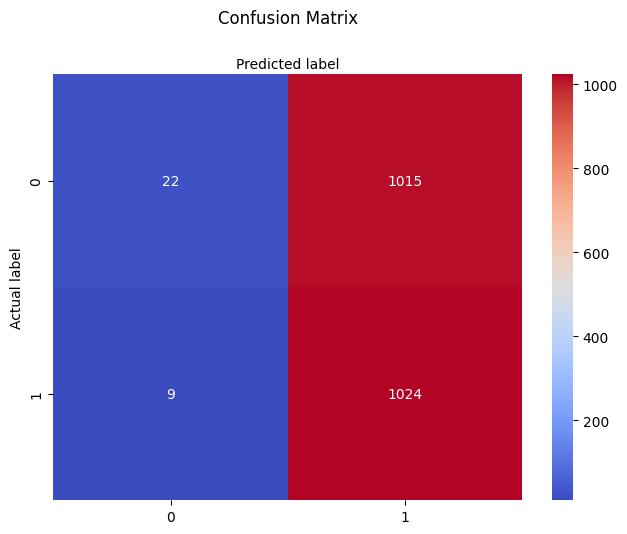

In [620]:
# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# visualize confusion matrix with a heatmap
class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# heatmap
sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap='coolwarm', fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion Matrix", y=1.1)
plt.xlabel("Predicted label")
plt.ylabel("Actual label")

### New Classification Report

In [621]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.02      0.04      1037
           1       0.50      0.99      0.67      1033

    accuracy                           0.51      2070
   macro avg       0.61      0.51      0.35      2070
weighted avg       0.61      0.51      0.35      2070



## Check for overfitting

### Logistic Regression

In [622]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Predictions on training and test sets
y_train_pred = log_model.predict(X_train)
y_test_pred = log_model.predict(X_test)

# AUC-ROC scores
train_auc = roc_auc_score(y_train, log_model.predict_proba(X_train)[:, 1])
test_auc = roc_auc_score(y_test, log_model.predict_proba(X_test)[:, 1])
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5)

print(f"Mean CV Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Train):\n", classification_report(y_train, y_train_pred))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))
print("\nAUC-ROC Train:", train_auc)
print("AUC-ROC Test:", test_auc)

Mean CV Accuracy: 0.849 (+/- 0.026)
Train Accuracy: 0.8354675042280744
Test Accuracy: 0.8342995169082126

Classification Report (Train):
               precision    recall  f1-score   support

           0       0.83      0.84      0.84      4137
           1       0.84      0.83      0.83      4141

    accuracy                           0.84      8278
   macro avg       0.84      0.84      0.84      8278
weighted avg       0.84      0.84      0.84      8278


Classification Report (Test):
               precision    recall  f1-score   support

           0       0.84      0.82      0.83      1037
           1       0.83      0.85      0.84      1033

    accuracy                           0.83      2070
   macro avg       0.83      0.83      0.83      2070
weighted avg       0.83      0.83      0.83      2070


AUC-ROC Train: 0.9240122928085447
AUC-ROC Test: 0.9218723307328739


No overfitting from the Logistic Regression. 
* Overall model accuracy stayed the same between training and testing.
* Recall increased when the model was exposed to new data which indicates the model found good patterns in the training data and was able to learn those patterns instead of memorizing them
* AUC-ROC value is close to 1 for both the train and test sets which indicates that the model can predict the right outcome around 92% of the time

### Random Forest

In [623]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Predictions on training and test sets
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# AUC-ROC scores
train_auc = roc_auc_score(y_train, best_rf.predict_proba(X_train)[:, 1])
test_auc = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1])
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5)

print(f"Mean CV Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Train):\n", classification_report(y_train, y_train_pred))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))
print("\nAUC-ROC Train:", train_auc)
print("AUC-ROC Test:", test_auc)

Mean CV Accuracy: 0.849 (+/- 0.026)
Train Accuracy: 0.9289683498429573
Test Accuracy: 0.5053140096618357

Classification Report (Train):
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      4137
           1       0.93      0.93      0.93      4141

    accuracy                           0.93      8278
   macro avg       0.93      0.93      0.93      8278
weighted avg       0.93      0.93      0.93      8278


Classification Report (Test):
               precision    recall  f1-score   support

           0       0.71      0.02      0.04      1037
           1       0.50      0.99      0.67      1033

    accuracy                           0.51      2070
   macro avg       0.61      0.51      0.35      2070
weighted avg       0.61      0.51      0.35      2070


AUC-ROC Train: 0.9861189306111141
AUC-ROC Test: 0.8525112931878669


We can see clear overfit for the Random Forest
* Training accuracy is significantly higher than the testing accuracy which means the model just memorized the training data, thus failing to predict the correct outcomes when met with new data
* Though the AUC-ROC values are high, the testing value is much lower than the training value, again indicating overfit

# Final Thoughts

Based on the classification reports and the AUC-ROC values, we were able to identify that the Logisitc Regression is the better model for prediciting customer churn in this dataset. The Random Forest performed poorly as it suffered from overfitting. This could be due to the fact that there are linear relationships between the features and the target variable which would make the simpler logistic regression outperfom the random forest since random forests thrive off of complex, non-linear data. Let's confirm if our features and target variable have a linear relationship

### Verify Feature Relationship with Target Variable

By checking the coefficients of our features, we can identify what features have a linear relationship with the target variable. Since we implemented SMOTE oversampling on the training set, we need to make sure that the coefficients remained intact after oversampling to ensure we didn't alter any fundamental relationships in the original data.

In [624]:
coefficients = pd.DataFrame({"Feature": X.columns, "Coefficient": log_model.coef_[0]})
coefficients = coefficients.sort_values(by="Coefficient", ascending=False)
print("\nCoefficients BEFORE oversampling the training data:")
print(coefficients)

coefficient_after_SMOTE = pd.DataFrame({"Feature": X_resampled.columns, "Coefficient": log_model.coef_[0]})
coefficient_after_SMOTE = coefficient_after_SMOTE.sort_values(by="Coefficient", ascending=False)
print("\nCoefficients AFTER oversampling the training data:")
print(coefficient_after_SMOTE)


Coefficients BEFORE oversampling the training data:
                                    Feature  Coefficient
29                        count_of_services     6.183588
10                           MonthlyCharges     4.454657
14                       InternetService_no     2.250085
11                             TotalCharges     1.161888
15                  Contract_month-to-month     0.317369
27           TenureCategory_3_plus_customer     0.142979
23                     PackageTier_high_end     0.116963
20           PaymentMethod_electronic check     0.113331
25                      PackageTier_premium     0.025667
24                     PackageTier_mid_tier     0.015270
28              TenureCategory_new_customer     0.012842
18  PaymentMethod_bank transfer (automatic)    -0.013183
16                        Contract_one year    -0.025194
12                      InternetService_dsl    -0.051319
19    PaymentMethod_credit card (automatic)    -0.057387
21               PaymentMethod_mail

Coefficients match up which means we successfully didn't alter any relationships with the oversampling technique. We can also see from the high negative or positive coefficients that a decent amount of our features have linear relationships with the target variable

Now that we see that select features have a linear relationship with the target variable, it makes sense why the logistic regression would perform better than the Random Forest.